<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 2: Deep learning для обработки звука</center></h2>

# Введение

В этом задании Вы поработаете и разберетесь в деталях с форматами представления аудиоданных в задачах глубинного обучения, а так же напишете несколько моделей для классификации аудиозаписей.

В процессе выполнения Вы познакомитесь:
* С алгоритмом построения Мел-спектрограммы.
* Рекуррентными и сверточными классификаторами аудиоданных.
* Алгоритмом аугментации аудиоданных SpecAugment.

In [ ]:
!pip install torch==1.8.0 torchaudio==0.8.0 numpy==1.20.0

In [ ]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset

import torchaudio

assert torch.__version__.startswith('1.8.0')
assert torchaudio.__version__ == '0.8.0'

device='cuda:0'

# Классификация аудиозаписей.

В этом домашнем задании Вам предстоит классифицировать аудиозаписи из датасета [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html).

Данный датасет состоит из 8732 записей, разбитых на train/val/test датасеты. 

![image](https://paperswithcode.com/media/datasets/UrbanSound8K-0000003722-02faef06.jpg)

Каждая аудиозапись содержит запись шума города и принадлежит одному из 10 классов: 

`[air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music]`


## Задание 1 (1 балл). Знакомство с данными.

1. Скачайте датасет из [Google Drive](https://drive.google.com/file/d/12emmtpodmo1783e6VOOEjV20zAKl5dZR/view?usp=sharing) c и распакуйте в папку `./data`.

2. Напишите `AudioDataset` класс, который будет принимать путь к файлам `train_part.csv` и `val_part.csv` и возращать тройки объектов `(x, y, len)`, где `x` - аудиозапись, `y` - класс аудиозаписи, `len` - длина аудиозаписи. Аудиозаписи **не должны постоянно храниться в RAM**, подгрузку _wav_ файлов надо сделать при запросе через `__getitem__` метод. Кроме того, надо сделать паддинг аудиозаписи - если она короче чем `pad_size` параметр, надо дополнять ее нулями.

3. С помощью функции `display.Audio` проиграйте в ноутбуке пару аудиозаписей.


In [ ]:
# скачаем и распакуем данные
!rm -r ./data
!mkdir ./data/
!pip install gdown
!cd ./data && gdown https://drive.google.com/uc?id=15-PunkgS_-7Nq93V8spxZC2oziGq5Jau && unzip HW2_dataset.zip && rm HW2_dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: urbansound8k/data/712.wav  
  inflating: urbansound8k/data/1286.wav  
  inflating: urbansound8k/data/7768.wav  
  inflating: urbansound8k/data/855.wav  
  inflating: urbansound8k/data/1319.wav  
  inflating: urbansound8k/data/15.wav  
  inflating: urbansound8k/data/2610.wav  
  inflating: urbansound8k/data/3268.wav  
  inflating: urbansound8k/data/5619.wav  
  inflating: urbansound8k/data/6310.wav  
  inflating: urbansound8k/data/6304.wav  
  inflating: urbansound8k/data/4513.wav  
  inflating: urbansound8k/data/2162.wav  
  inflating: urbansound8k/data/2604.wav  
  inflating: urbansound8k/data/841.wav  
  inflating: urbansound8k/data/699.wav  
  inflating: urbansound8k/data/6462.wav  
  inflating: urbansound8k/data/869.wav  
  inflating: urbansound8k/data/8467.wav  
  inflating: urbansound8k/data/7754.wav  
  inflating: urbansound8k/data/7032.wav  
  inflating: urbansound8k/data/3254.wav  
  inflating: ur

In [ ]:
# классы данных
classes = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
           'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 
           'siren', 'street_music']

In [ ]:
import os

import pandas as pd
import numpy as np


class AudioDataset(Dataset):
    def __init__(self, path_to_csv: str, 
                 path_to_folder: str, 
                 pad_size: int=384000,
                 sr: int = 44100):
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)[['ID', 'Class']]
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size

        self.sr = sr

        self.class_to_idx = {classes[i]: i for i in range(10)}

    def __getitem__(self, index: int):
        ### YOUR CODE IS HERE ######
        
        audio_class = self.class_to_idx[self.csv.iloc[index]['Class']]
        audio_id = self.csv.iloc[index]['ID']
        audio_path = self.path_to_folder + '/' + str(audio_id) + '.wav'

        # Load audio and reshape
        audio = torchaudio.load(audio_path, channels_first=False)[0][:self.pad_size].view(-1)
        audio_len = len(audio)

        # Make padding if needed
        padding = (0, max(0, self.pad_size - audio_len))
        audio = nn.functional.pad(audio, padding)
        
        return {
            'x': audio,
            'y': audio_class,
            'len': audio_len
        }
        
        ### THE END OF YOUR CODE ###

    def __len__(self):
        return self.csv.shape[0]

In [ ]:
# создадим датасеты
train_dataset = AudioDataset('./data/urbansound8k/train_part.csv', './data/urbansound8k/data')
val_dataset = AudioDataset('./data/urbansound8k/val_part.csv', './data/urbansound8k/data')

In [ ]:
# проверим размеры датасетов
assert len(train_dataset) == 4500
assert len(val_dataset) == 935

In [ ]:
# проверим возращаемые значения __getitem__
item = train_dataset.__getitem__(0)

assert item['x'].shape == (384000, )
assert item['y'] == 0
assert item['len'] == 176400

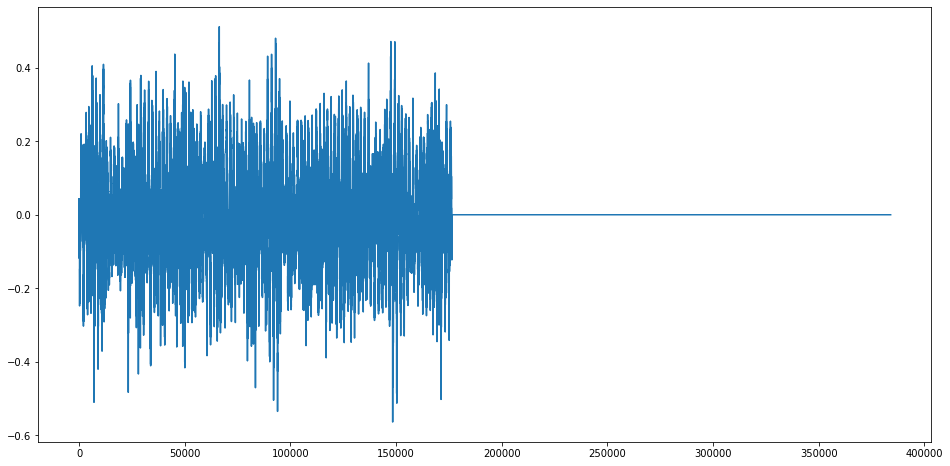

In [ ]:
# нарисуем и проиграем аудиозаписить
item = train_dataset.__getitem__(0)
plt.figure(figsize=(16, 8))
plt.plot(item['x'])

display.Audio(item['x'], rate=train_dataset.sr)

In [ ]:
# создадим даталоадеры
train_dataloader = DataLoader(train_dataset, 32, shuffle=True,
                              pin_memory=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, 32,
                            pin_memory=True)

## Задание 2. Рекуррентная сеть для классификации аудиозаписей по сырому сигналу (2 балла)

По своей сути аудиозапись является ни чем иным, как временным рядом - замеры микрофона делаются через равные промежутки времени и хранятся в виде последовательности. 

Как известно, рекуррентные сети отлично подходят для работы с различными последовательностями, в том числе и с временными рядами.

Обучим простую реккурентную сеть для классификации аудиозаписей.

1. Разбейте аудизаписить на окошки размером `1024` с шагом `256`. Для этих целей отлично подойдет метод `torch.Tensor.unfold`.
1. Применим к каждому получившемуся окну аудиосигнала полносвязную сеть с активациями `ReLU` и  внутренними размерностям `(1024 -> 256 -> 64 -> 16)`.
2. По получившимся последовательностям пройдемся двунаправленой (`bidirectional=True`) LSTM с двумя слоями (`layers=2`).
3. Склеим c помощью `torch.cat` последние `hidden_state` для каждого слоя и применим к ним полносвязную сеть `(2 * hidden_size * num_layers -> 256 -> 10)` с активацией `ReLU`.

![title](https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw2/imgs/rnn_raw.png?raw=1)

*Совет*: для убыстрения обучения имеет смысл в полносвязные сети добавить `BatchNorm`.

In [331]:
class RecurrentRawAudioClassifier(nn.Module):
  def __init__(self, 
               num_classes=10,
               window_length=1024,
               hop_length=256,
               hidden=256,
               num_layers=2):
    super().__init__()

    self.window_length = window_length
    self.hop_length = hop_length

    ### YOUR CODE IS HERE ######
    self.first_mlp = nn.Sequential(
        nn.Linear(window_length, 256),
        # nn.BatchNorm1d(256),
        nn.ReLU(),

        nn.Linear(256, 64),
        # nn.BatchNorm1d(64),
        nn.ReLU(),

        nn.Linear(64, 16),
        # nn.BatchNorm1d(16),
        nn.ReLU()
    )

    self.rnn = nn.LSTM(
        input_size=16,
        hidden_size=hidden,
        num_layers=num_layers,
        bidirectional=True, 
        batch_first=True
    )

    self.final_mlp = nn.Sequential(
        nn.Linear(2 * hidden * num_layers, 256),
        # nn.BatchNorm1d(256),
        nn.ReLU(),

        nn.Linear(256, num_classes),
        # nn.BatchNorm1d(num_classes),
        nn.ReLU()
    )
    ### THE END OF YOUR CODE ###

  def forward(self, x, lens):
    # разбейте сигнал на окна 
    # batch_windows.shape == (B, NUM WINDOWS, 1024)
    batch_size = x.shape[0]
    batch_windows = x.unfold(1, self.window_length, self.hop_length)  #your code here

    # примените к каждому окну полносвязную сеть
    # batch_windows_feautures.shape == (B, NUM WINDOWS, 16)
    ### YOUR CODE IS HERE ###
    input_shape = (*batch_windows.shape[:2], 16)
    batch_windows_feautures = torch.zeros(input_shape, device=device)
    for i in range(batch_size):
        batch_windows_feautures[i] = self.first_mlp(batch_windows[i])
    ### THE END OF YOUR CODE ###

    # примените к получившемся последовательностям LSTM и возьмите hidden state
    ### YOUR CODE IS HERE ###
    # Output of rnn: (output, (h_n, c_n))
    # last hidden states from every layer and direction are in h_n: [1][0]
    lstm_feautures = self.rnn(batch_windows_feautures)[1][0].transpose(0, 1)
    ### THE END OF YOUR CODE ###

    # склейте hidden_state по слоям
    # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
    hidden_flattened = nn.Flatten()(lstm_feautures) # your code here

    # примените полносвязную сеть и получим логиты классов
    return self.final_mlp(hidden_flattened) #your code here

In [ ]:
#@title forward c использовнием длин сигналов (lens)
#@markdown Неэффективно, несмотря на то, что на падинге не обучаемся.
#@markdown Много циклов, работает медленно.
  def forward(self, x, lens):
    # разбейте сигнал на окна 
    # batch_windows.shape == (B, NUM WINDOWS, 1024)
    batch_size = x.shape[0]
    batch_windows = []
    for i in range(batch_size):
        batch_windows.append(x[i][:lens[i]].unfold(0, self.window_length, self.hop_length))
    # batch_windows = x.unfold(1, self.window_length, self.hop_length)  #your code here

    # примените к каждому окну полносвязную сеть
    # batch_windows_feautures.shape == (B, NUM WINDOWS, 16)
    ### YOUR CODE IS HERE ###
    # input_shape = (*batch_windows.shape[:2], 16)
    # batch_windows_feautures = torch.zeros(input_shape, device=device)
    batch_windows_feautures = [0]*batch_size
    for i in range(batch_size):
        batch_windows_feautures[i] = self.first_mlp(batch_windows[i])
    ### THE END OF YOUR CODE ###

    # примените к получившемся последовательностям LSTM и возьмите hidden state
    ### YOUR CODE IS HERE ###
    # Output of rnn: (output, (h_n, c_n))
    # last hidden states from every layer and direction are in h_n: [1][0]
    lstm_feautures = [0]*batch_size
    for i in range(batch_size):
        lstm_feautures[i] = self.rnn(batch_windows_feautures[i].unsqueeze(0))[1][0]
    lstm_feautures = torch.cat(lstm_feautures, dim=1).transpose(0, 1)
    ### THE END OF YOUR CODE ###

    # склейте hidden_state по слоям
    # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
    hidden_flattened = nn.Flatten()(lstm_feautures) # your code here

    # примените полносвязную сеть и получим логиты классов
    return self.final_mlp(hidden_flattened) #your code here

Обучим получившуюся модель.

In [ ]:
from IPython.display import clear_output

def train_audio_clfr(model, optimizer, train_dataloader, sr,
                     criterion=torch.nn.CrossEntropyLoss(),
                     data_transform=None, 
                     augmentation=None,
                     num_epochs=10, device='cuda:0',
                     verbose_num_iters=10):
  model.train()
  iter_i = 0

  train_losses = []
  train_accuracies = []

  for epoch in range(num_epochs):  
    for batch in train_dataloader:
        x = batch['x'].to(device)
        y = batch['y'].to(device)
        lens = batch['len'].to(device)
        
        # применяем преобразование входных данных
        if data_transform:
          x, lens = data_transform(x,
                                   lens, 
                                   device=device, 
                                   sr=sr)

        # примеменяем к логмелспектрограмме аугментацию
        if augmentation:
          x, lens = augmentation(x, lens)

        # делаем предсказания
        probs = model(x, lens)

        # делаем шаг градиента
        optimizer.zero_grad()
        loss = criterion(probs, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        # считаем точность предсказания
        pred_cls = probs.argmax(dim=-1)
        train_accuracies.append((pred_cls == y).float().mean().item())
    
        iter_i += 1

        # раз в verbose_num_iters визуализируем наши лоссы и семплы
        if iter_i % verbose_num_iters == 0:
            clear_output(wait=True)

            print(f'Epoch {epoch}')

            plt.figure(figsize=(10, 5))
                
            plt.subplot(1, 2, 1)
            plt.xlabel('Iteration')
            plt.ylabel('Train loss')
            plt.plot(np.arange(iter_i), train_losses)

            plt.subplot(1, 2, 2)
            plt.xlabel('Iteration')
            plt.ylabel('Train acc')
            plt.plot(np.arange(iter_i), train_accuracies)

            plt.show()

  model.eval()

In [ ]:
# создадим объекты модели и оптимизатор
rnn_raw = RecurrentRawAudioClassifier()
rnn_raw.to(device);

optim = torch.optim.Adam(rnn_raw.parameters(), lr=3e-4)

Epoch 9


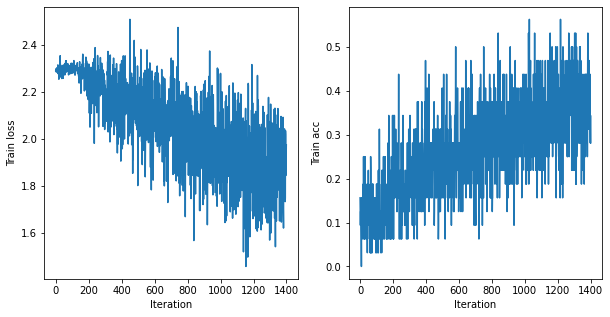

In [ ]:
# обучим модель
train_audio_clfr(rnn_raw, optim, train_dataloader, train_dataset.sr)

Посчитаем метрики на валидационном датасете.

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, val_dataloader, sr, device, data_transform=None):
  pred_true_pairs = []
  for batch in val_dataloader:
        x = batch['x'].to(device)
        y = batch['y'].to(device)
        lens = batch['len'].to(device)
        
        with torch.no_grad():
          if data_transform:
            x, lens = data_transform(x, lens, sr=sr, device=device)

          probs = model(x, lens)

          pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
          pred_true_pairs.append((pred, true))

  print(f'Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs])}')

  cm_df = pd.DataFrame(
      confusion_matrix([p[1] for p in pred_true_pairs], 
                       [p[0] for p in pred_true_pairs], 
                       normalize='true'),
      columns=classes, index=classes)
  sn.heatmap(cm_df, annot=True)

Val accuracy: 0.3090909090909091


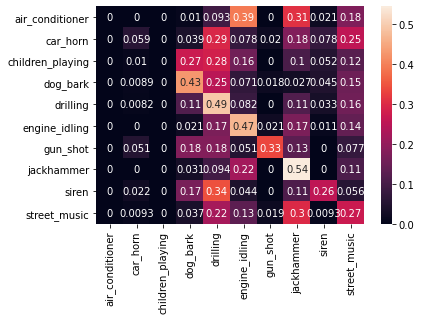

In [ ]:
# Качество на тесте
plot_confusion_matrix(rnn_raw, val_dataloader, train_dataset.sr, device)

Val accuracy: 0.3691964285714286


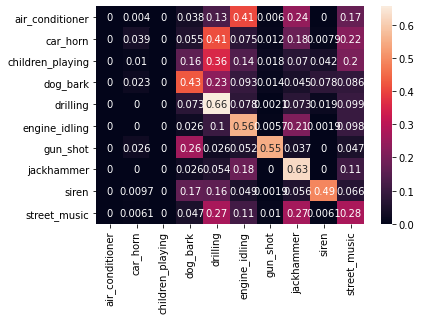

In [ ]:
# Качество на трейне
plot_confusion_matrix(rnn_raw, train_dataloader, train_dataset.sr, device)

*Вопрос* : Сильно ли отличается качество модели на тренировочной и валидационной выборке? Если да, то как думаете, в чем причина?

Ремарка: убрал batchnorm, accuracy после 10 эпох обучения на тестовой выборке выросло с 15% до 31%, на тренировочной - с 20% до 37%. Скорее всего из-за нормализации входные сигналы становяться очень похожи, к этому добавляется еще падинг, который также вносит свой негативный вклад.

Качество на тестовой и тренировочной выборках разниться незначительно. Это говорит о том, что модель вполне сносно генерализирует полученную информацию. В то же время 31% - это довольно низкий результат. 

Также вызывает вопросы то, что нейросеть практически не распознает 3 класса: кондиционеры, гудки автомобилей и звуки играющих детей. При этом, в тренировочной выборке данные классы довольно общирно представлены.

In [ ]:
count_classes = [0]*10
for i in train_dataset:
    count_classes[i['y']] += 1
for i, c in enumerate(classes):
    print('Total number of', c, 'is', count_classes[i])

Total number of air_conditioner is 503
Total number of car_horn is 255
Total number of children_playing is 504
Total number of dog_bark is 488
Total number of drilling is 478
Total number of engine_idling is 530
Total number of gun_shot is 191
Total number of jackhammer is 541
Total number of siren is 517
Total number of street_music is 493


## Задание 3. Построение Мел-cпектрограмм. (2 балла)

Сырой сигнал очень чувствителен ко многим факторам - увеличение/уменьшение громкости, внешние шумы, сменение тембра говорящего очень резко меняют сырой сигнал. Это влияет и на качество глубоких сетей, обученных на сыром аудиосигнале.

Для построения надежных и устойчивых к переобучению моделей используют другое представление аудиоданных - спектрограммы, в том числе Мел-спектрограмму.

Идея её построения заключается в следующем:
1. Сигнал разбивается на временные интервалы (с пересечениями)
2. К каждому временному интервалу применяется фильтр (как правило косинусоидальный)
3. К профильтрованному сигналу применяется дискретное преобразование Фурье и вычисляются спектральные признаки сигнала.
4. Спектральные признаки с помощью логарифмического преобразования приводятся в Мел-шкалу.

![image](https://antkillerfarm.github.io/images/img2/Spectrogram_5.png)

В этом задании мы сами шаг за шагом напишем алгоритм построения мелспектрограммы и сравнимся с референсной функцией из `torchaudio`.

In [289]:
from torchaudio.transforms import MelSpectrogram

# референсная функця
def compute_log_melspectrogram_reference(wav_batch, 
                                         lens,
                                         sr,
                                         device='cpu'):
  featurizer = MelSpectrogram(
      sample_rate=sr,
      n_fft=1024,
      win_length=1024,
      hop_length=256,
      n_mels=64,
      center=False,
      ).to(device)

  return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

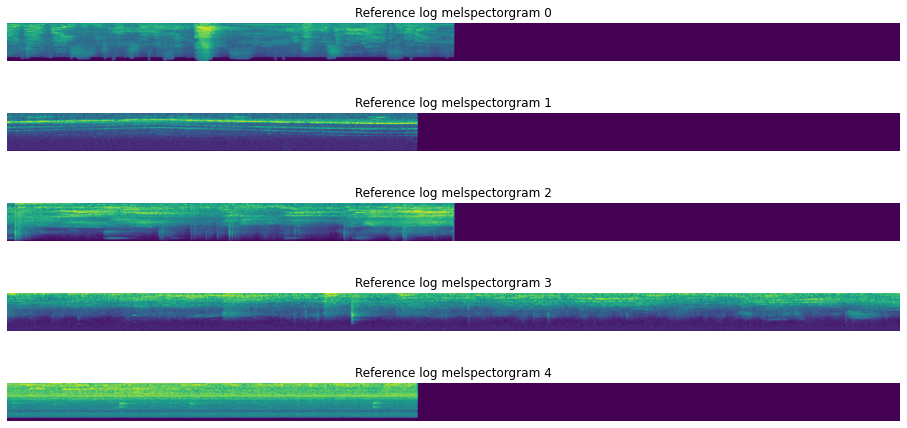

In [290]:
# возьмем случайный батч
for batch in train_dataloader:
  break
wav_batch = batch['x']
lens = batch['len']

# посчитаем лог мелспектрограммы
log_melspect, lens = compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)

# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
  axes[i].axis('off')
  axes[i].set_title(f'Reference log melspectorgram {i}')
  axes[i].imshow(log_melspect[i].numpy())

Теперь сделаем то же самое сами. 

In [291]:
sr = train_dataset.sr
n_fft=1024
win_length=1024
hop_length=256
n_mels=64


Для начала с помощью метода `unfold` разделим аудиосигнал на окна размера `win_lenght` через промежутки `hop_lenght`.

In [292]:
windows = wav_batch.unfold(1, win_length, hop_length) # your code here
assert windows.shape == (32, 1497, 1024)

Нарисуем и проиграем сигнал из одного окна.

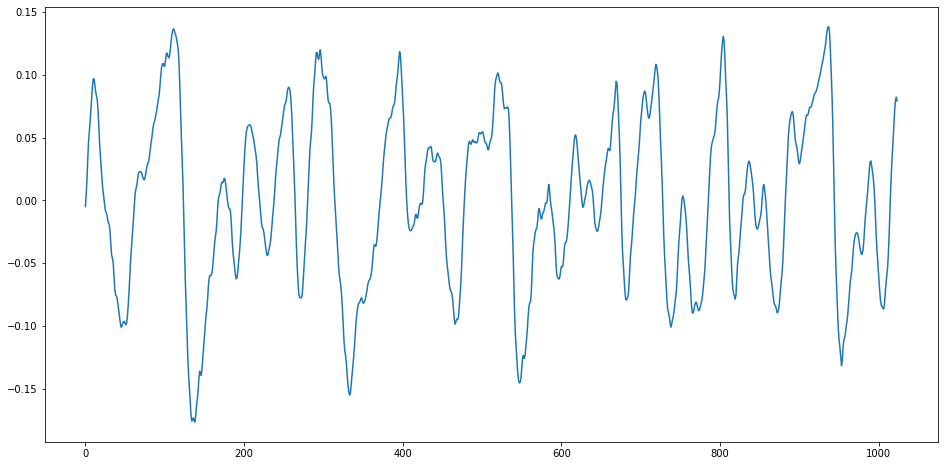

In [293]:
plt.figure(figsize=(16, 8))
plt.plot(windows[0, 0])

display.Audio(windows[0, 0], rate=train_dataset.sr)

Теперь нам надо применить косинуисальный фильтр к сигналу из окна. Для этого с помощью `torch.hann_window` создадим косинусоидальный фильтр и умножим его поэлементно на все окна.

In [294]:
filter = torch.hann_window(win_length) # your code here
windows_with_applied_filter = windows * filter[None, None, :]

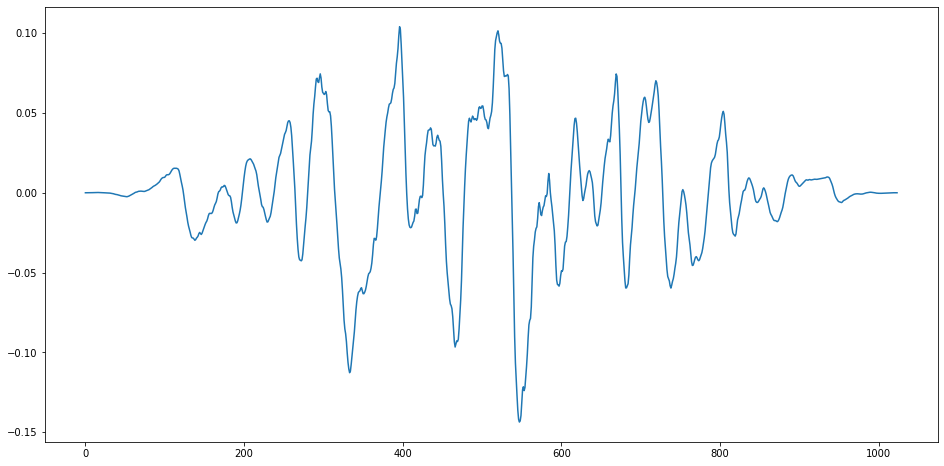

In [295]:
plt.figure(figsize=(16, 8))
plt.plot(windows_with_applied_filter[0, 0])

display.Audio(windows_with_applied_filter[0, 0], rate=train_dataset.sr)

С помощью `torch.fft.fft` примените дискретное преобразование фурье к каждому окну и возьмите первые `n_fft // 2 + 1` компоненты.

Дальше с помощью возведения элементов тензора в квадрат и `torch.abs()` получите магнитуды.

In [304]:
fft_features = torch.fft.fft(windows_with_applied_filter)[:,:,:n_fft // 2 + 1] # your code here
fft_magnitudes = torch.abs(fft_features ** 2)
assert fft_magnitudes.shape == (32, 1497, 513)

Через `torchaudio.transforms.MelScale` создайте класс для перевода магнитуд в Мел-шкалу.

In [305]:
melscale = torchaudio.transforms.MelScale(n_mels, sr, n_stft=n_fft // 2 + 1) # your code here

Нелинейное преобразование для перевода в Мел-шкалу выглядит следующим образом.

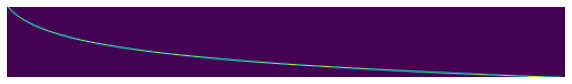

In [306]:
plt.figure(figsize=(10, 5))
plt.axis('off')
plt.imshow(melscale.fb.numpy().transpose())

Примените Мел-шкалу к магнитудам.

In [307]:
mel_spectrogram = melscale(fft_magnitudes.transpose(1, 2)) # your code here
assert mel_spectrogram.shape == (32, 64, 1497)

Сделайте обрезку значений по `1e-5` и примените `torch.log` для получения логарифмированной Мел-спектрограммы.

In [308]:
logmel_spectrogram = torch.log(mel_spectrogram.clip(1e-5)) # your code here
assert logmel_spectrogram.shape == (32, 64, 1497)

Полученные логарифмированные Мел-Спектрограммы должны совпадать с референсными.

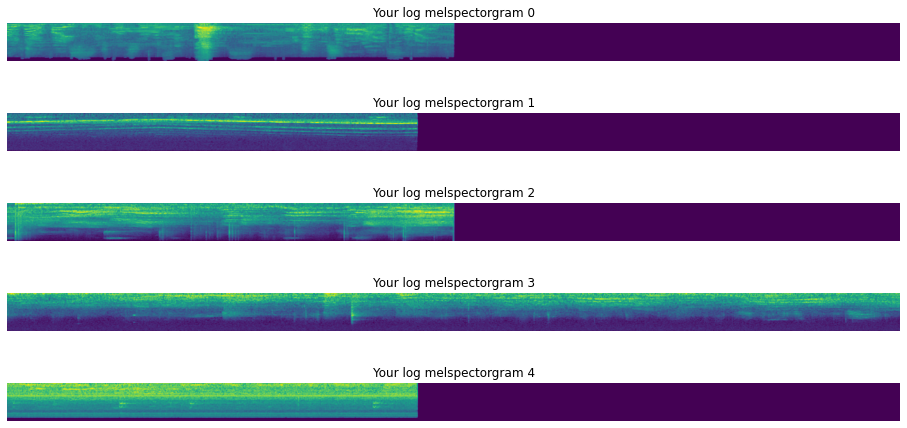

In [309]:
# нарисуем получившиеся значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
  axes[i].axis('off')
  axes[i].set_title(f'Your log melspectorgram {i}')
  axes[i].imshow(logmel_spectrogram[i].numpy())

Теперь оформим эту логику в функцию.

In [321]:
# ваша реализация
def compute_log_melspectrogram(wav_batch,
                               lens,
                               sr,
                               device='cpu'):
    ### YOUR CODE IS HERE ######
    windows = wav_batch.unfold(1, win_length, hop_length)

    filter = torch.hann_window(win_length).to(device)
    windows_with_applied_filter = windows * filter[None, None, :]

    fft_features = torch.fft.fft(windows_with_applied_filter)[:,:,:n_fft // 2 + 1]
    fft_magnitudes = torch.abs(fft_features ** 2)

    melscale = torchaudio.transforms.MelScale(n_mels, sr, n_stft=n_fft // 2 + 1).to(device)
    mel_spectrogram = melscale(fft_magnitudes.transpose(1, 2))

    return torch.log(mel_spectrogram.clip(1e-5)), lens // 256
    ### THE END OF YOUR CODE ###

Финальная проверка.

In [322]:
assert torch.allclose(
    compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0],
    compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)[0],
    atol=1e-5)

## Задание 4. Рекуррентная сеть для классификации аудиозаписей по логарифмированным Мел-спектрограммам (1 балл)

Измените реализацию рекуррентной сети из задания 2, таким образом, чтобы она вместо сырого сигнала смогла принимать логарифмированные Мел-спетрограммы:
1. Уберите шаги 1-2
2. Сделайте вход LSTM равным 64

![arch_mel](https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw2/imgs/rnn_mel.png?raw=1)

**За реализацию архитектуры дается 0.5 балла.**

In [332]:
class RecurrentMelSpectClassifier(nn.Module):
  def __init__(self, 
               num_classes=10,
               window_length=1024,
               hop_length=256,
               hidden=256,
               num_layers=2):
    super().__init__()

    self.window_length = window_length
    self.hop_length = hop_length

    ### YOUR CODE IS HERE ######
    self.rnn = nn.LSTM(
        input_size=64,
        hidden_size=hidden,
        num_layers=num_layers,
        bidirectional=True, 
        batch_first=True
    )

    self.final_mlp = nn.Sequential(
        nn.Linear(2 * hidden * num_layers, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),

        nn.Linear(256, num_classes),
        nn.BatchNorm1d(num_classes),
        nn.ReLU()
    )
    ### THE END OF YOUR CODE ###

  def forward(self, x, lens):
   ### YOUR CODE IS HERE ###### 
   lstm_feautures = self.rnn(x.transpose(1, 2))[1][0].transpose(0, 1)

   hidden_flattened = nn.Flatten()(lstm_feautures)

   return self.final_mlp(hidden_flattened) #your code here
   ### THE END OF YOUR CODE ###

In [333]:
rnn_mel = RecurrentMelSpectClassifier()
rnn_mel.to(device);

optim = torch.optim.Adam(rnn_mel.parameters(), lr=3e-4)


Epoch 9


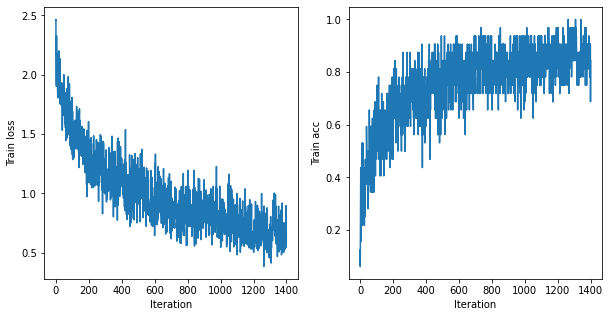

In [334]:
train_audio_clfr(rnn_mel, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram)

Посчитаем метрики на валидационном датасете.

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.8 на валидационном датасете.**

Val accuracy: 0.8160427807486631


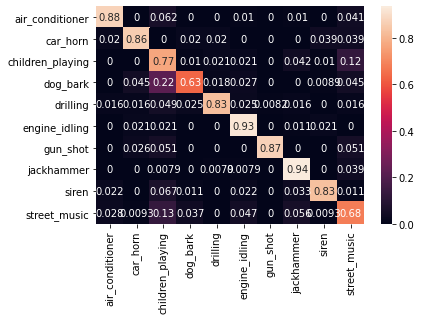

In [335]:
plot_confusion_matrix(rnn_mel, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)

## Задание 5. Cверточная сеть для классификации аудиозаписей по мелспектрограммам. (2 балла)

Легко заметить, что мелспектрограммы имеют четко выраженные паттерны - если приноровиться, то даже человек, посмотрев на мелспектрограмму, сможет _визуально_ проклассифицировать объект.

Это позволяет свести задачу классификации аудиозаписей к задаче классификации картинок.

Реализуем такую сверточную сеть:

* 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
* (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10

Совет: подобная архитектура была реализована в [**PANNs: Large-Scale Pretrained Audio Neural Networks for Audio Pattern Recognition**](https://arxiv.org/pdf/1912.10211.pdf), можете использовать эту статью как референс.


**За реализацию архитектуры дается 1.5 балла.**

In [366]:
class CNN10(nn.Module):
  def __init__(self, num_classes=10, hidden=16):
    super().__init__()

    ### YOUR CODE IS HERE ######
    self.cnn_backbone = nn.Sequential(
        nn.Conv2d(1, hidden, (3, 3), padding=1),
        nn.BatchNorm2d(hidden),
        nn.ReLU(),
        nn.Conv2d(hidden, hidden, (3, 3), padding=1),
        nn.BatchNorm2d(hidden),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), 

        nn.Conv2d(hidden, hidden*2, (3, 3), padding=1),
        nn.BatchNorm2d(hidden*2),
        nn.ReLU(),
        nn.Conv2d(hidden*2, hidden*2, (3, 3), padding=1),
        nn.BatchNorm2d(hidden*2),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), 

        nn.Conv2d(hidden*2, hidden*4, (3, 3), padding=1),
        nn.BatchNorm2d(hidden*4),
        nn.ReLU(),
        nn.Conv2d(hidden*4, hidden*4, (3, 3), padding=1),
        nn.BatchNorm2d(hidden*4),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), 

        nn.Conv2d(hidden*4, hidden*8, (3, 3), padding=1),
        nn.BatchNorm2d(hidden*8),
        nn.ReLU(),
        nn.Conv2d(hidden*8, hidden*8, (2, 2), padding=1),
        nn.BatchNorm2d(hidden*8),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), 
    )

    self.final_mlp = nn.Sequential(
        nn.Linear(hidden*8, hidden*8),
        nn.ReLU(),

        nn.Linear(hidden*8, num_classes)
    )
    ### THE END OF YOUR CODE ###

  def forward(self, x, lens):
    z = self.cnn_backbone(x[:, None, :, :])
    z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
    return self.final_mlp(z)

In [367]:
cnn = CNN10()
cnn.to(device);

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 10


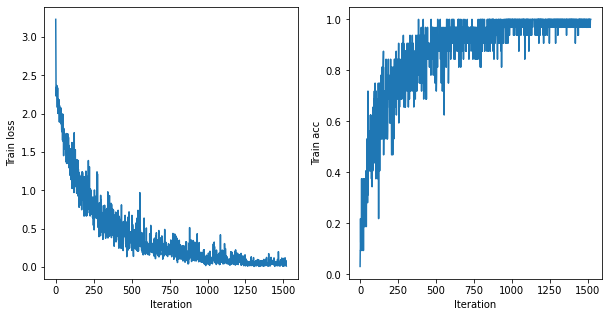

KeyboardInterrupt: ignored

In [368]:
train_audio_clfr(cnn, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram,
                 num_epochs=20)

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.85 на валидационном датасете.**

Val accuracy: 0.9219251336898395


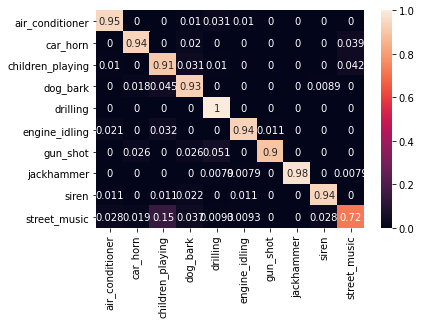

In [369]:
plot_confusion_matrix(cnn, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)

## Задание 6. Аугментация SpecAugment (2 балла)

Обычно датасеты с аудиозаписями довольно малы. Наш датасет тому пример - всего 4500 объектов в обучающей выборке. Обучение глубокий сетей с большим кол-вом параметров на таких датасетах часто ведет к переобучению и проседанию метрик на валидационном и тестовом датасетах.

Для борьбы с переобучением имеет смысл использовать аугментацию данных. Для мелспектрограмм была придумана аугментация под названием SpecAugment.

Смысл её очень прост - зануление спектрограммы по временным промежуткам и по мел-частотам:
1. Выбираются несколько временных промежутков ${[t^1_i, t^2_i]}$ и заполняют спектрограмму $s[t^1_i : t^2_i, :]$ значением $v$.

2. Выбираются несколько промежутков мелчастот ${[m^1_i, m^2_i]}$ и заполняют спектрограмму $s[:, m^1_i : m^2_i]$ значением $v$.

В качестве значения $v$ выбирают:
1. `'mean'`: среднее по спектрограмме
2. `'min'`: минимум по спектрограмме
3. `'max'`: максимум по спектрограмме
5. `v`: некоторая константа

Совет: описание аугментации можно найти здесь: [link](https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/), можете использовать эту ссылку как референс.

![specaugment](https://neurohive.io/wp-content/uploads/2019/04/image6.png)

В этом задании Вам предлагается реализовать аугментацию SpecAugment.

**За реализацию аугментации дается 1.5 балла.**


In [446]:
import random


class SpectAugment:
    def __init__(
        self,
        filling_value = 'mean',
        n_freq_masks = 2,
        n_time_masks = 2,
        max_freq = 10,
        max_time = 50,
    ):

        self.filling_value = filling_value
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_freq = max_freq
        self.max_time = max_time

    def __call__(self, spect, lens):
        ### YOUR CODE IS HERE ######
        # spect.shape = (batch_size, freq, time)

        # Клонируем спектрограмму, чтобы не переопределять оригинальную
        spect = torch.clone(spect)

        # Определим размеры выборки, частот и временного интервала
        batch_size = spect.shape[0]
        freq_len = spect.shape[1]
        time_len = spect.shape[2]

        # Для каждого объекта из батча определим значения, которым будем заполнять маску
        if self.filling_value == 'mean':
            filling_values = spect.mean(dim=(1, 2))
        elif isinstance(self.filling_value, int):
            filling_values = self.filling_value * torch.ones(batch_size)
        else:
            raise ValueError()
        
        # Проходимся по спектрограммам в батче
        for i in range(batch_size):
            for _ in range(self.n_freq_masks):
                # Длина маски, от 0 до 10 (включительно)
                mask_len = random.randrange(0, self.max_freq + 1)
                # Начальная позиция маски: mask_start + mask_len <= freq_len
                mask_start = random.randint(0, freq_len - mask_len)
                # Заполняем фрагмент нужными значениями
                spect[i, mask_start:mask_start + mask_len, :] = filling_values[i]
            
            for _ in range(self.n_time_masks):
                # Аналогично, только для времени :)
                mask_len = random.randrange(0, self.max_time + 1)
                mask_start = random.randint(0, time_len - mask_len)
                spect[i, :, mask_start:mask_start + mask_len] = filling_values[i]
            
        return spect, lens
        ### THE END OF YOUR CODE ###

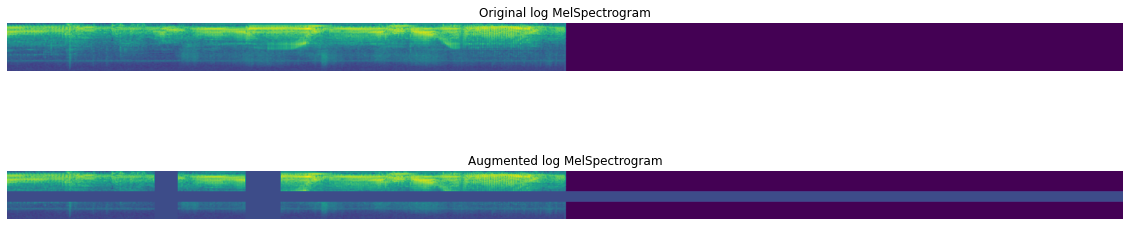

In [447]:
# применим аугментацию к данным
for batch in train_dataloader:
  break

x = batch['x'].to(device)
lens = batch['len'].to(device)
x_logmel, lens = compute_log_melspectrogram_reference(x, lens, sr=train_dataset.sr, device=device)
x_logmel_augmented, lens = SpectAugment()(x_logmel, lens)

# нарисуем спектрограмму до и после аугментации
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title('Original log MelSpectrogram')
plt.axis('off')
plt.imshow(x_logmel[0].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title('Augmented log MelSpectrogram')
plt.axis('off')
plt.imshow(x_logmel_augmented[0].cpu().numpy())

In [448]:
cnn = CNN10()
cnn.to(device);

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 19


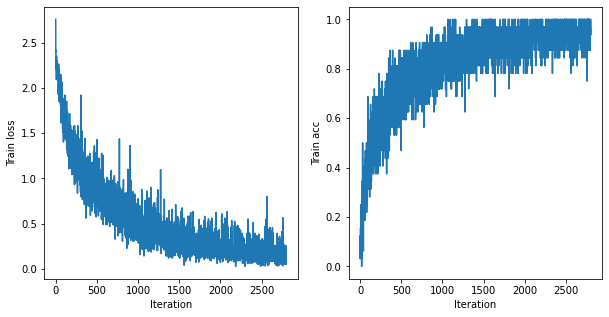

In [449]:
# обучим модель на данных с аугментациями
train_audio_clfr(cnn, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram,
                 augmentation=SpectAugment(),
                 num_epochs=20)

**Задание: для получения 0.5 балла сделайте подбор параметров аугментации и добейтесь accuracy модели выше 0.9 на валидационном датасете.**

Val accuracy: 0.9176470588235294


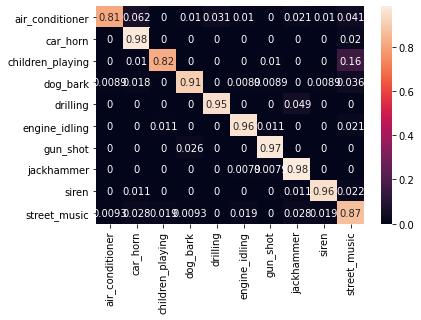

In [450]:
plot_confusion_matrix(cnn, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)

Качество чуть хуже чем без аугументаций (да еще из 20 эпох!!), но выше 0,9. Пойдет :)